In [1]:
from tqdm import tqdm_notebook as tqdm

In [2]:
import glob
import zarr
import dask.bag as db
import dask.array as da
plt.style.use('tableau-colorblind10')

paths = glob.glob('../data/runs/model268-epoch5.nudge/OUT_3D/*.pt')

# drop the initial path since it doens't have the data
paths = paths[1:]

In [3]:
state = torch.load(paths[0])

group = zarr.open_group('nudging.zarr', mode='w')
variables = {}
n = len(paths)

for key in state:
    try:
        ds = group.create_dataset(key, data=[state[key]])
        size = (n,) + ds.shape[1:]
        ds.resize(size)
        variables[key] = ds
    except ValueError:
        print(f"Skipping {key}")

Skipping _DIMS
Skipping _ATTRIBUTES


In [4]:
import dask.bag as db
from dask.diagnostics import ProgressBar

paths_db = db.from_sequence(enumerate(paths))

def add_file_to_zarr(args):
    k, path = args
    state = torch.load(path)
    for key, val in variables.items():
        val[k] = state[key]

with ProgressBar():
    paths_db.map(add_file_to_zarr).compute()

[########################################] | 100% Completed | 24.5s


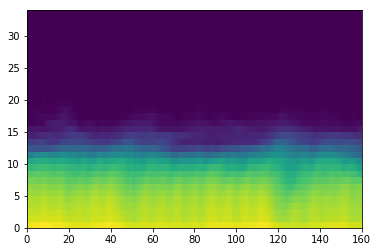

In [5]:
plt.pcolormesh(group.total_water_mixing_ratio[:, :, 32, 0].T)

In [6]:
qt_n = da.from_zarr(group.tendency_of_liquid_ice_static_energy_due_to_nudging)
qt_nn = da.from_zarr(group.tendency_of_liquid_ice_static_energy_due_to_neural_network)

In [7]:
mean_qt = qt_n.mean(axis=(0, -1)).compute()

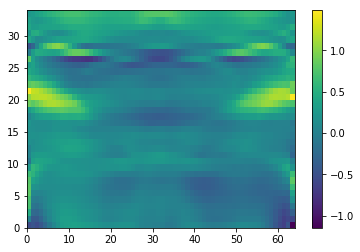

In [8]:
plt.pcolormesh(mean_qt)
plt.colorbar()

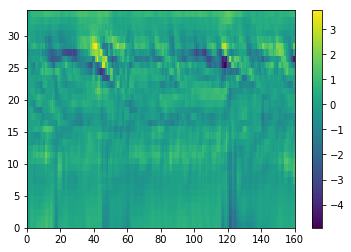

In [9]:
plt.pcolormesh(qt_n[:,:,32,0].T)
plt.colorbar()

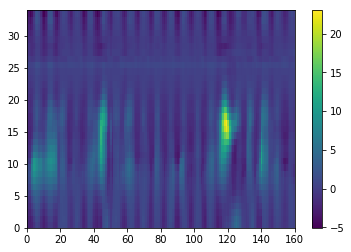

In [10]:
plt.pcolormesh(qt_nn[:,:,32,0].T)
plt.colorbar()

# Momentum

In [11]:
qt_n = da.from_zarr(group.tendency_of_y_wind_due_to_nudging)

In [12]:
mean_qt = qt_n.mean(axis=(0, -1)).compute()

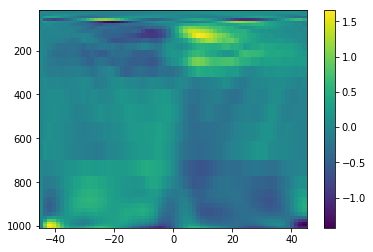

In [13]:
p = group.air_pressure[0]
y = group.latitude[0, 0,:,0]

def plot_y_p(mean_qt, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    im = ax.pcolormesh(y, p, mean_qt)
    ax.invert_yaxis()
    plt.colorbar(im, ax=[ax])
    
plot_y_p(mean_qt)

This shows that the nudging terms are maintaining the Hadley circulation.

# Vertical Velocity

In [14]:
z_wind_mean = group.upward_air_velocity[:].mean(axis=(0, -1))

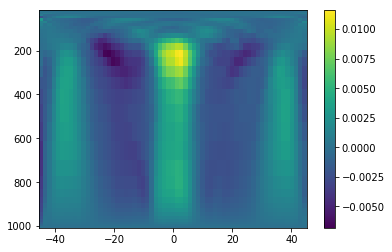

In [15]:
plot_y_p(z_wind_mean)

Let's compare this to NG-Aqua

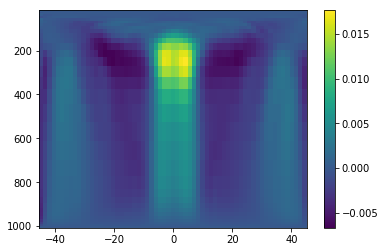

In [16]:
from src.data import open_data

ds = open_data('training')

ng_z_wind_mean = ds['W'].mean(['x', 'time'])
plot_y_p(ng_z_wind_mean.values)

These magnitudes look stronger in NG-Aqua than the nudged run. A line plot makes the point more clear:

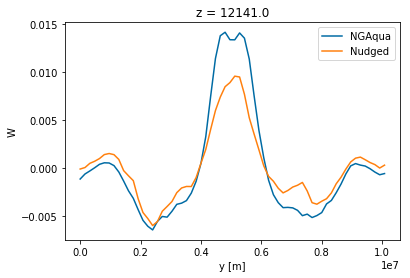

In [17]:
ng_z_wind_mean[20].plot(label='NGAqua')
plt.plot(ng_z_wind_mean.y, z_wind_mean[20], label='Nudged')
plt.legend()

The nudged run has too little vertical motion in the tropics. Why? Is Q1 off?

# Q1 

Let's compare the heating generated by

1. NG-=Aqua
2. cSAM + NN + Nudging



In [21]:
import torch
from uwnet.xarray_interface import call_with_xr

ds = open_data('training_with_src').isel(time=slice(0, 160))


model = torch.load("../models/268/5.pkl")
semi_prognostic = call_with_xr(model, ds)
ds = ds.assign({'Q1NN': semi_prognostic.SLI, 'Q2NN': semi_prognostic.QT})

In [22]:
ng_q1_mean = ds.Q1.mean(['x', 'time'])
nudged_q1_mean = group.tendency_of_liquid_ice_static_energy[:].mean(axis=(0, -1))
nn_q1_mean = ds.Q1NN.mean(['x', 'time'])

plotme = xr.concat([xr.DataArray(nudged_q1_mean, dims=['z', 'y']), ng_q1_mean, nn_q1_mean],
                   dim=['Nudge', 'NG', 'Semi-prognostic'])

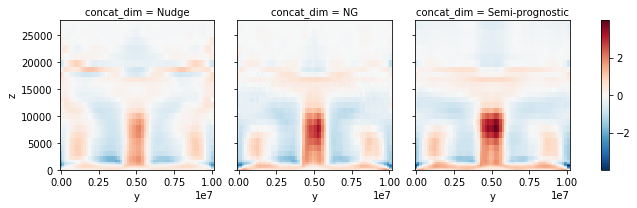

In [23]:
plotme.plot(col='concat_dim')

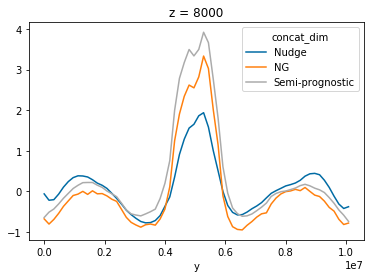

In [24]:
plotme.interp(z=8000).plot(hue='concat_dim')

This run **needs more heating**. The semi-prognostic Q1 is also biased, but not by as much.

# Conclusions

The nudged run does not produce enough heating in the tropics, and therefore does not create enough vertical velocity in the tropics. To make up for this, the nudging terms force the v-winds to be quite strong.